# _Şehir Bazlı Ev Kira Fiyat Tahmini: Web Scraping ve Derin Öğrenme ile Regression Modeli_

<img src='https://images.squarespace-cdn.com/content/v1/58412fc9b3db2b11ba9398df/1635114222379-LE26YRRHTRRT2P6NAO1F/202105281227_1.jpg?format=1000w'>

_Bu projede, Türkiye’deki bir şehirdeki konut kiralarını tahmin etmek amaçlanmaktadır. Öncelikle, popüler emlak sitelerinden (Zingat, Hepsiemlak, Emlakjet) web scraping yöntemi ile kira ilanları toplanacaktır. Toplanan veriler; semt, oda sayısı, büyüklük, kat bilgisi ve diğer özellikler gibi etkenleri içerecek şekilde işlenecek ve eksik veriler temizlenecektir._

_Veri hazırlandıktan sonra, makine öğrenmesi algoritmaları (Linear Regression, Random Forest vb.) ve TensorFlow/Keras ile derin öğrenme modelleri kullanılarak kira fiyatları tahmin edilecektir. Modelin performansı RMSE, MAE ve R² gibi metriklerle değerlendirilecek ve tahminlerin doğruluğu analiz edilecektir._

### _Web Scraping_

#### _İmport_

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import random 

#### _Headers_

In [2]:
# Site bizim bot attığımızı düşünmesin, normal kullanıcı olarak düşünsün diye header ekliyoruz.

In [3]:
headers = {'User-Agent' : 'Mozilla/5.0'}

#### _Base Url_

In [4]:
base_url='https://www.emlakjet.com/satilik-konut/istanbul/'
page= [f"{base_url}{i}" for i in range(1,50)]

print(page)

['https://www.emlakjet.com/satilik-konut/istanbul/1', 'https://www.emlakjet.com/satilik-konut/istanbul/2', 'https://www.emlakjet.com/satilik-konut/istanbul/3', 'https://www.emlakjet.com/satilik-konut/istanbul/4', 'https://www.emlakjet.com/satilik-konut/istanbul/5', 'https://www.emlakjet.com/satilik-konut/istanbul/6', 'https://www.emlakjet.com/satilik-konut/istanbul/7', 'https://www.emlakjet.com/satilik-konut/istanbul/8', 'https://www.emlakjet.com/satilik-konut/istanbul/9', 'https://www.emlakjet.com/satilik-konut/istanbul/10', 'https://www.emlakjet.com/satilik-konut/istanbul/11', 'https://www.emlakjet.com/satilik-konut/istanbul/12', 'https://www.emlakjet.com/satilik-konut/istanbul/13', 'https://www.emlakjet.com/satilik-konut/istanbul/14', 'https://www.emlakjet.com/satilik-konut/istanbul/15', 'https://www.emlakjet.com/satilik-konut/istanbul/16', 'https://www.emlakjet.com/satilik-konut/istanbul/17', 'https://www.emlakjet.com/satilik-konut/istanbul/18', 'https://www.emlakjet.com/satilik-ko

In [5]:
# for i in range(1,30) = 1den 30a kadar olan sayfaları çek demektir.

#### _House Links_

In [6]:
house= []

# tüm sayfaları dönmesi için for döngüsü ekliyorum.
for url in page:
    response= requests.get(url, headers=headers)

    # veriyi çekip çekemediğimizi kontrol ediyoruz. Eğer 200 geliyorsa çekebiliyoruz, yasak değil izin veriyor demektir.
    if response.status_code == 200:
        soup= bs(response.content, 'html.parser')

        # şimdi divleri almaya başlayabiliriz.
        # find_all = yazdığım şeyden ne kadar varsa getir.
        listings= soup.find_all('div', class_='styles_listingWrapper__gVjYi') # class'ı ... olan tüm divleri getir.

        # div in içerisinde ihtiyacım olmayan veriler olduğu için filtreleme yapıyorum;
        for listing in listings:
            if listing.find('div', class_='styles_housingProjectWrapper__KTA1a'):
                continue

            # artık a ları bulabiliriz;
            link_tag= listing.find('a', href=True)

            if link_tag:
                full_link= 'https://www.emlakjet.com/' + link_tag['href']
                house.append(full_link)

In [7]:
len(house)

1646

In [8]:
house

['https://www.emlakjet.com//ilan/toprak-insaat-kullanima-hazir-iskan-alinmis-31-cadde-uzeri-18672518',
 'https://www.emlakjet.com//ilan/kozyatagi-avsar-sokakta-minibus-cd-yakin-daireye-ait-garaj-genis-21-luks-18671531',
 'https://www.emlakjet.com//ilan/pendik-guzelyalida-satilik-21-asansor-otoparkli-ana-cadde-ustu-luks-daire-18666448',
 'https://www.emlakjet.com//ilan/beylikduzu-metrobuse-10-dk-marmarapark-avm-yakin-site-ici-21-daire-18659628',
 'https://www.emlakjet.com//ilan/bayrampasa-orta-mh-de-31-satilik-daire-18649687',
 'https://www.emlakjet.com//projeler/proje/avrasya-konutlari-cadde',
 'https://www.emlakjet.com//ilan/metrobuse-yakin-havuzlu-guvenlikli-site-icinde-21-luks-daire-18672881',
 'https://www.emlakjet.com//ilan/merkezi-konumda-metrobuse-yakin-11-site-ici-luks-daire-18672338',
 'https://www.emlakjet.com//ilan/yilmaz-emlak-tan-silivri-alibey-de-31-4-kat-satilik-daire-18659613',
 'https://www.emlakjet.com//ilan/metrobuse-5dk-full-donanimli-site-ici-ebeveyn-banyolu-21-gen

#### _DataFrame_

In [9]:
import pandas as pd
import numpy as np

In [10]:
# yeni bir boş liste belirleyip gelen veriyi bunun için kaydedelim.
house_data= []

# tüm verileri tek tek dolaşıp istediğim verileri bana çekmesi için for döngüsü oluşturuyorum.
for house_url in house:
    response= requests.get(house_url, headers=headers)
    
    # tekrar çekmeme izin verecek mi kontrol etmem lazım;
    if response.status_code==200:
        soup= bs(response.content, 'html.parser')

        # datalar için yeni bir sözlük oluşturuyorum;
        house_info= {}

        price_span= soup.find('span', class_='styles_price__6wmxk') # bir tane olduğu için find ı kullanıyorum. Ve span olduğunu belirtiyorum.
        # şimdi price_span in text ini almam lazım
        # ayırmasını yapması için strip=True ekliyorum.
        # eğer price yoksa nan yazdırsın
        price= price_span.get_text(strip=True) if price_span else np.nan

        location_span= soup.find('span', class_='styles_location__HguIg')
        # eğer location varsa yapsın, yoksa yapmasın;
        if location_span:
            location_text= location_span.get_text(strip=True)
            # şimdi bunu parçalamam lazım. Çünkü sadece ilk iki kelimeyi çekmek istiyorum.
            location_parts= location_text.split('-') # - ile parçaladım 3 e bölündü.
            # parçalanan location içerisinden ilk ikisini alıp aralarına - eklemek için;
            # location_parts >= ise bunu yap değilse nan dönsün;
            location= '-'.join(location_parts[:2]) if len(location_parts) >= 2 else np.nan
        else:
            location= np.nan # eğer yukarıdaki şartlara uymuyorsa nan dönsün

        features_div= soup.find('div', class_='styles_inner__qKPCB')
        # eğer doluysa gelsin, boşsa gelmesin;
        if features_div:
            # içerisindeki li leri çekmek için;
            li_tags= features_div.find_all('li') # hepsini çekmek istediğim için find_all kullanıyorum.
            # her li nin içerisindeki span lere ulaşmak için for döngüsü kullanıyorum;
            for li in li_tags:
                spans=li.find_all('span') # li nin içerisndeki tüm spanleri almasını söylüyorum
                # belki fazla olur ya da az olur bu yüzden kontrol ediyorum;
                if len(spans) == 2:
                    # ilk span i key e ikinci span i value ye atıcaz;
                    key= spans[0].get_text(strip=True)
                    value= spans[1].get_text(strip=True)
                    # key ve value yü belirtip sözlüğe ekliyorum.
                    house_info[key]=value

            # price ve locationu da ekliyelim;
            house_info['Fiyat']= price
            house_info['Location']= location
            # kontrol etmek istersek diye ilan linkini ekleyelim
            house_info['İlan Linki']= house_url


            # her bir sözlüğü house_data nın içerisine atıyorum;
            house_data.append(house_info)

In [11]:
df= pd.DataFrame(house_data1)

In [12]:
df.head()

,İlan Numarası,İlan Oluşturma Tarihi,İlan Güncelleme Tarihi,Türü,Kategorisi,Tipi,Net Metrekare,Brüt Metrekare,Oda Sayısı,Binanın Yaşı,...,İlan Linki,Aidat,Banyo Metrekare,Salon Metrekare,Ada,Parsel,WC Metrekare,Balkon Metrekare,Pafta,Kattaki Daire Sayısı
0,18672518,22 Aralık 2025,22 Aralık 2025,Konut,Satılık,Daire,115 m²,120 m²,3+1,0 (Yeni),...,https://www.emlakjet.com//ilan/toprak-insaat-k...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18671531,22 Aralık 2025,22 Aralık 2025,Konut,Satılık,Daire,75 m²,90 m²,2+1,11-15,...,https://www.emlakjet.com//ilan/kozyatagi-avsar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18666448,21 Aralık 2025,21 Aralık 2025,Konut,Satılık,Daire,80 m²,90 m²,2+1,0 (Yeni),...,https://www.emlakjet.com//ilan/pendik-guzelyal...,0 TL,5 m²,22 m²,NaN,NaN,NaN,NaN,NaN,NaN
3,18659628,20 Aralık 2025,21 Aralık 2025,Konut,Satılık,Daire,100 m²,110 m²,2+1,5-10,...,https://www.emlakjet.com//ilan/beylikduzu-metr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18649687,19 Aralık 2025,19 Aralık 2025,Konut,Satılık,Daire,105 m²,125 m²,3+1,21 Ve Üzeri,...,https://www.emlakjet.com//ilan/bayrampasa-orta...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### _To_Csv_

In [207]:
df.to_csv('house_data.csv', index=False)

### _İmport_

In [157]:
import pandas as pd
pd.set_option('display.max_columns', 55)  
# Pandas DataFrame çıktılarında tüm sütunların görünmesini sağlar.

import warnings
warnings.filterwarnings('ignore')  
# Uyarıları gizler, böylece kod çalışırken kullanıcıyı rahatsız etmez.

from sklearn.linear_model import LinearRegression, Ridge, Lasso
# LinearRegression: Doğrusal regresyon modelini kullanır.
# Ridge: L2 regularizasyonu ile doğrusal regresyon.
# Lasso: L1 regularizasyonu ile doğrusal regresyon.

from sklearn.model_selection import train_test_split
# Veriyi eğitim ve test setlerine ayırır.

from sklearn.metrics import r2_score, mean_squared_error
# r2_score: Modelin açıklama gücünü ölçer.
# mean_squared_error: Modelin hata oranını ölçer, kareler ortalaması hatası.

import numpy as np  # NumPy, matematiksel ve matris işlemleri için kullanılır.

import matplotlib.pyplot as plt 
# Veriyi görselleştirmek için grafikler çizen kütüphane.

import seaborn as sns 
# Veri görselleştirme kütüphanesi, genellikle daha estetik ve kompleks grafikler oluşturur.

In [158]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.models import Sequential
# Sequential: katmanları sırayla ekleyerek model kurmamızı sağlar

from tensorflow.keras.layers import Dense
# Dense: tam bağlantılı (fully connected) yapay sinir ağı katmanı

import matplotlib.pyplot as plt
# Grafik çizimleri (plot) yapmak için kullanılan kütüphane

from tensorflow.keras.callbacks import EarlyStopping
# EarlyStopping: Eğitim sırasında belirli bir metrik iyileşmeyi durdurduğunda
# modeli otomatik olarak durduran callback yapısıdır.
# Overfitting'i engellemek ve gereksiz yere uzun eğitim süresini azaltmak için kullanılır.

### _Data Dosyası Okuma_

In [209]:
df = pd.read_csv('house_data1.csv')

### _Data Preprocessing_

#### _Eda_

In [210]:
df.head()  
# DataFrame'in ilk 5 satırını gösterir. Veri yapısının hızlıca gözlemlenmesi için kullanılır.

,Net Metrekare,Brüt Metrekare,Binanın Yaşı,Binanın Kat Sayısı,Fiyat,oda,salon,Tipi_Daire,Tipi_Köşk,Tipi_Müstakil Ev,Tipi_Residence,Tipi_Villa,Tipi_Yalı Dairesi,Tipi_Yazlık,Isıtma Tipi_Güneş Enerjisi,Isıtma Tipi_Isıtma Yok,Isıtma Tipi_Klimalı,Isıtma Tipi_Kombi Doğalgaz,Isıtma Tipi_Kombi Fueloil,Isıtma Tipi_Merkezi (Pay Ölçer),Isıtma Tipi_Merkezi Doğalgaz,Isıtma Tipi_Sobalı,Isıtma Tipi_VRV,Isıtma Tipi_Yerden Isıtma,Kullanım Durumu_Kiracı Oturuyor,Kullanım Durumu_Mülk Sahibi Oturuyor,Tapu Durumu_Hisseli Tapu,Tapu Durumu_Kat Mülkiyeti,Tapu Durumu_Kat İrtifakı,Tapu Durumu_Müstakil Tapulu,Tapu Durumu_Tapu Kaydı Yok,Tapu Durumu_Yabancıdan,Site İçerisinde_Hayır,Eşya Durumu_Eşyalı,Eşya Durumu_Eşyasız,Banyo Sayısı_2,Banyo Sayısı_3,Banyo Sayısı_4,Banyo Sayısı_5,Banyo Sayısı_6+,Banyo Sayısı_Yok,Balkon Durumu_Yok,Fiyat Durumu_Genel Fiyat,Location_İstanbul - Ataşehir,Location_İstanbul - Avcılar,Location_İstanbul - Bahçelievler,Location_İstanbul - Bakırköy,Location_İstanbul - Bayrampaşa,Location_İstanbul - Bağcılar,Location_İstanbul - Başakşehir,Location_İstanbul - Beykoz,Location_İstanbul - Beylikdüzü,Location_İstanbul - Beyoğlu,Location_İstanbul - Beşiktaş,Location_İstanbul - Büyükçekmece,Location_İstanbul - Esenler,Location_İstanbul - Esenyurt,Location_İstanbul - Eyüpsultan,Location_İstanbul - Fatih,Location_İstanbul - Gaziosmanpaşa,Location_İstanbul - Güngören,Location_İstanbul - Kadıköy,Location_İstanbul - Kartal,Location_İstanbul - Kağıthane,Location_İstanbul - Küçükçekmece,Location_İstanbul - Maltepe,Location_İstanbul - Pendik,Location_İstanbul - Sancaktepe,Location_İstanbul - Sarıyer,Location_İstanbul - Silivri,Location_İstanbul - Sultanbeyli,Location_İstanbul - Sultangazi,Location_İstanbul - Tuzla,Location_İstanbul - Zeytinburnu,Location_İstanbul - Çatalca,Location_İstanbul - Çekmeköy,Location_İstanbul - Ümraniye,Location_İstanbul - Üsküdar,Location_İstanbul - Şile,Location_İstanbul - Şişli
0,115.0,120.0,7.5,4,8500000,3.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,75.0,90.0,13.0,7,13950000,2.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,80.0,90.0,7.5,4,6000000,2.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,100.0,110.0,7.5,24,1990000,2.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,105.0,125.0,7.5,4,4500000,3.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,

In [211]:
df.tail()  
# DataFrame'in son 5 satırını gösterir. Verinin son kısmına bakmak için kullanılır.

,Net Metrekare,Brüt Metrekare,Binanın Yaşı,Binanın Kat Sayısı,Fiyat,oda,salon,Tipi_Daire,Tipi_Köşk,Tipi_Müstakil Ev,Tipi_Residence,Tipi_Villa,Tipi_Yalı Dairesi,Tipi_Yazlık,Isıtma Tipi_Güneş Enerjisi,Isıtma Tipi_Isıtma Yok,Isıtma Tipi_Klimalı,Isıtma Tipi_Kombi Doğalgaz,Isıtma Tipi_Kombi Fueloil,Isıtma Tipi_Merkezi (Pay Ölçer),Isıtma Tipi_Merkezi Doğalgaz,Isıtma Tipi_Sobalı,Isıtma Tipi_VRV,Isıtma Tipi_Yerden Isıtma,Kullanım Durumu_Kiracı Oturuyor,Kullanım Durumu_Mülk Sahibi Oturuyor,Tapu Durumu_Hisseli Tapu,Tapu Durumu_Kat Mülkiyeti,Tapu Durumu_Kat İrtifakı,Tapu Durumu_Müstakil Tapulu,Tapu Durumu_Tapu Kaydı Yok,Tapu Durumu_Yabancıdan,Site İçerisinde_Hayır,Eşya Durumu_Eşyalı,Eşya Durumu_Eşyasız,Banyo Sayısı_2,Banyo Sayısı_3,Banyo Sayısı_4,Banyo Sayısı_5,Banyo Sayısı_6+,Banyo Sayısı_Yok,Balkon Durumu_Yok,Fiyat Durumu_Genel Fiyat,Location_İstanbul - Ataşehir,Location_İstanbul - Avcılar,Location_İstanbul - Bahçelievler,Location_İstanbul - Bakırköy,Location_İstanbul - Bayrampaşa,Location_İstanbul - Bağcılar,Location_İstanbul - Başakşehir,Location_İstanbul - Beykoz,Location_İstanbul - Beylikdüzü,Location_İstanbul - Beyoğlu,Location_İstanbul - Beşiktaş,Location_İstanbul - Büyükçekmece,Location_İstanbul - Esenler,Location_İstanbul - Esenyurt,Location_İstanbul - Eyüpsultan,Location_İstanbul - Fatih,Location_İstanbul - Gaziosmanpaşa,Location_İstanbul - Güngören,Location_İstanbul - Kadıköy,Location_İstanbul - Kartal,Location_İstanbul - Kağıthane,Location_İstanbul - Küçükçekmece,Location_İstanbul - Maltepe,Location_İstanbul - Pendik,Location_İstanbul - Sancaktepe,Location_İstanbul - Sarıyer,Location_İstanbul - Silivri,Location_İstanbul - Sultanbeyli,Location_İstanbul - Sultangazi,Location_İstanbul - Tuzla,Location_İstanbul - Zeytinburnu,Location_İstanbul - Çatalca,Location_İstanbul - Çekmeköy,Location_İstanbul - Ümraniye,Location_İstanbul - Üsküdar,Location_İstanbul - Şile,Location_İstanbul - Şişli
1419,240.0,260.0,7.5,4,30000000,5.0,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1420,240.0,270.0,7.5,4,14750000,4.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1421,90.0,110.0,7.5,5,6500000,3.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1422,55.0,70.0,7.5,5,6975000,2.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1423,120.0,125.0,18.0,5,5500000,3.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,True,Fa

In [162]:
df.describe()  
# Sayısal sütunlar için temel istatistiksel bilgileri (ortalama, standart sapma, min, max vs.) döker.

,İlan Numarası,Binanın Kat Sayısı,Ada,Parsel,Kattaki Daire Sayısı
count,1.424000e+03,1424.000000,47.000000,6.700000e+01,1.0
mean,1.863632e+07,6.356742,2142.978723,2.813172e+05,1.0
std,1.678249e+05,4.863042,3280.501874,2.292729e+06,NaN
min,1.646322e+07,1.000000,0.000000,1.000000e+00,1.0
25%,1.865527e+07,4.000000,260.000000,7.000000e+00,1.0
50%,1.866428e+07,5.000000,605.000000,1.700000e+01,1.0
75%,1.867057e+07,6.000000,2521.000000,5.500000e+01,1.0
max,1.867619e+07,35.000000,15509.000000,1.876800e+07,1.0


In [163]:
df.info()  
# DataFrame hakkında genel bilgi verir (sütun isimleri, veri tipi, boş değer sayısı vb.).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   İlan Numarası              1424 non-null   int64  
 1   İlan Oluşturma Tarihi      1404 non-null   object 
 2   İlan Güncelleme Tarihi     1424 non-null   object 
 3   Türü                       1424 non-null   object 
 4   Kategorisi                 1424 non-null   object 
 5   Tipi                       1424 non-null   object 
 6   Net Metrekare              1424 non-null   object 
 7   Brüt Metrekare             1424 non-null   object 
 8   Oda Sayısı                 1424 non-null   object 
 9   Binanın Yaşı               1424 non-null   object 
 10  Bulunduğu Kat              1372 non-null   object 
 11  Binanın Kat Sayısı         1424 non-null   int64  
 12  Isıtma Tipi                1424 non-null   object 
 13  Kullanım Durumu            1424 non-null   objec

In [164]:
df.sample()
# Veri setinden rastgele bir satır (veya satırlar) getirir.

,İlan Numarası,İlan Oluşturma Tarihi,İlan Güncelleme Tarihi,Türü,Kategorisi,Tipi,Net Metrekare,Brüt Metrekare,Oda Sayısı,Binanın Yaşı,Bulunduğu Kat,Binanın Kat Sayısı,Isıtma Tipi,Kullanım Durumu,Krediye Uygunluk,Yatırıma Uygunluk,Yapı Durumu,Yapı Tipi,Tapu Durumu,Site İçerisinde,İpotek Durumu,Eşya Durumu,Kira Getirisi,Takas,Banyo Sayısı,Balkon Durumu,Balkon Sayısı,Balkon Tipi,WC Sayısı,Fiyat Durumu,Görüntülü Gezilebilir mi?,Zemin Etüdü,Fiyat,Location,İlan Linki,Aidat,Banyo Metrekare,Salon Metrekare,Ada,Parsel,WC Metrekare,Balkon Metrekare,Pafta,Kattaki Daire Sayısı
1053,18655873,19 Aralık 2025,22 Aralık 2025,Konut,Satılık,Daire,45 m²,55 m²,1+1,21 Ve Üzeri,Düz Giriş (Zemin),3,Kombi Doğalgaz,Boş,Krediye Uygun Değil,Yatırıma Uygun,İkinci El,Betonarme,Arsa Tapulu,Hayır,Yok,Boş,15000 TL,Var,1,Var,NaN,NaN,1,Genel Fiyat,Hayır,NaN,1.200.000TL,İstanbul - Pendik,https://www.emlakjet.com//ilan/satilik-daire-p...,NaN,NaN,NaN,5027.0,12.0,NaN,NaN,NaN,NaN


In [165]:
df.shape  
# DataFrame'in boyutlarını (satır sayısı, sütun sayısı) döker.

(1424, 44)

#### _Missing Value Imputation_

In [166]:
df.isnull().sum()  
# Hangi sütunlarda kaç tane eksik (null) değer olduğunu sayar.

İlan Numarası                   0
İlan Oluşturma Tarihi          20
İlan Güncelleme Tarihi          0
Türü                            0
Kategorisi                      0
Tipi                            0
Net Metrekare                   0
Brüt Metrekare                  0
Oda Sayısı                      0
Binanın Yaşı                    0
Bulunduğu Kat                  52
Binanın Kat Sayısı              0
Isıtma Tipi                     0
Kullanım Durumu                 0
Krediye Uygunluk                0
Yatırıma Uygunluk             711
Yapı Durumu                  1260
Yapı Tipi                    1268
Tapu Durumu                     0
Site İçerisinde                 0
İpotek Durumu                1317
Eşya Durumu                   795
Kira Getirisi                1310
Takas                         305
Banyo Sayısı                    0
Balkon Durumu                1255
Balkon Sayısı                1323
Balkon Tipi                  1343
WC Sayısı                    1302
Fiyat Durumu  

In [167]:
drop_cols = [
    "İlan Numarası",
    "İlan Oluşturma Tarihi",
    "İlan Güncelleme Tarihi",
    "İlan Linki",
    "Ada",
    "Parsel",
    "Pafta",
    "Zemin Etüdü",
    "Yatırıma Uygunluk",
    "Kira Getirisi",
    "Takas",
    "İpotek Durumu",
    "Krediye Uygunluk",
    "Balkon Sayısı",
    "Balkon Tipi",
    "Balkon Metrekare",
    "WC Sayısı",
    "WC Metrekare",
    "Banyo Metrekare",
    "Salon Metrekare",
    "Yapı Tipi",
    "Yapı Durumu",
    "Görüntülü Gezilebilir mi?",
    "Kattaki Daire Sayısı",
    "Aidat", "Bulunduğu Kat"
]

df.drop(columns=drop_cols, inplace=True)

In [168]:
df.isnull().sum()

Türü                     0
Kategorisi               0
Tipi                     0
Net Metrekare            0
Brüt Metrekare           0
Oda Sayısı               0
Binanın Yaşı             0
Binanın Kat Sayısı       0
Isıtma Tipi              0
Kullanım Durumu          0
Tapu Durumu              0
Site İçerisinde          0
Eşya Durumu            795
Banyo Sayısı             0
Balkon Durumu         1255
Fiyat Durumu             0
Fiyat                    0
Location                 0
dtype: int64

In [169]:
df["Eşya Durumu"] = df["Eşya Durumu"].fillna("Eşyasız")

In [170]:
df["Balkon Durumu"] = df["Balkon Durumu"].fillna("Yok")

In [171]:
df.isnull().sum()

Türü                  0
Kategorisi            0
Tipi                  0
Net Metrekare         0
Brüt Metrekare        0
Oda Sayısı            0
Binanın Yaşı          0
Binanın Kat Sayısı    0
Isıtma Tipi           0
Kullanım Durumu       0
Tapu Durumu           0
Site İçerisinde       0
Eşya Durumu           0
Banyo Sayısı          0
Balkon Durumu         0
Fiyat Durumu          0
Fiyat                 0
Location              0
dtype: int64

### _Feature Engineering_

In [172]:
df.sample()

,Türü,Kategorisi,Tipi,Net Metrekare,Brüt Metrekare,Oda Sayısı,Binanın Yaşı,Binanın Kat Sayısı,Isıtma Tipi,Kullanım Durumu,Tapu Durumu,Site İçerisinde,Eşya Durumu,Banyo Sayısı,Balkon Durumu,Fiyat Durumu,Fiyat,Location
334,Konut,Satılık,Daire,100 m²,125 m²,3+1,11-15,4,Kombi Doğalgaz,Boş,Kat Mülkiyeti,Hayır,Boş,2,Yok,Genel Fiyat,8.600.000TL,İstanbul - Bayrampaşa


In [173]:
df["Fiyat"] = (
    df["Fiyat"]
    .astype(str)
    .str.replace("TL", "")
    .str.replace(".", "")
    .str.replace(",", "")
)

df["Fiyat"] = pd.to_numeric(df["Fiyat"])

In [174]:
df["Net Metrekare"] = (
    df["Net Metrekare"]
    .astype(str)
    .str.replace("m²", "", regex=False)
    .str.replace(" ", "", regex=False)
)

df["Net Metrekare"] = pd.to_numeric(df["Net Metrekare"], errors="coerce")

df["Brüt Metrekare"] = (
    df["Brüt Metrekare"]
    .astype(str)
    .str.replace("m²", "", regex=False)
    .str.replace(" ", "", regex=False)
)

df["Brüt Metrekare"] = pd.to_numeric(df["Brüt Metrekare"], errors="coerce")

In [175]:
df["Oda Sayısı"] = df["Oda Sayısı"].astype(str)

df["oda"] = df["Oda Sayısı"].str.split("+").str[0]
df["salon"] = df["Oda Sayısı"].str.split("+").str[1]

df["oda"] = pd.to_numeric(df["oda"], errors="coerce")
df["salon"] = pd.to_numeric(df["salon"], errors="coerce")

df.drop("Oda Sayısı", axis=1, inplace=True)

In [176]:
def yas_convert(x):
    if isinstance(x, str) and "-" in x:
        a, b = x.split("-")
        return (int(a) + int(b)) / 2
    return pd.to_numeric(x, errors="coerce")

df["Binanın Yaşı"] = df["Binanın Yaşı"].apply(yas_convert)

In [177]:
df.isnull().sum()

Türü                    0
Kategorisi              0
Tipi                    0
Net Metrekare           0
Brüt Metrekare          0
Binanın Yaşı          757
Binanın Kat Sayısı      0
Isıtma Tipi             0
Kullanım Durumu         0
Tapu Durumu             0
Site İçerisinde         0
Eşya Durumu             0
Banyo Sayısı            0
Balkon Durumu           0
Fiyat Durumu            0
Fiyat                   0
Location                0
oda                     6
salon                   7
dtype: int64

In [178]:
df["oda"] = df["oda"].fillna(df["oda"].median())
df["salon"] = df["salon"].fillna(df["salon"].median())

In [179]:
df["Binanın Yaşı"] = df["Binanın Yaşı"].fillna(
    df["Binanın Yaşı"].median()
)

In [180]:
df.isnull().sum()

Türü                  0
Kategorisi            0
Tipi                  0
Net Metrekare         0
Brüt Metrekare        0
Binanın Yaşı          0
Binanın Kat Sayısı    0
Isıtma Tipi           0
Kullanım Durumu       0
Tapu Durumu           0
Site İçerisinde       0
Eşya Durumu           0
Banyo Sayısı          0
Balkon Durumu         0
Fiyat Durumu          0
Fiyat                 0
Location              0
oda                   0
salon                 0
dtype: int64

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Türü                1424 non-null   object 
 1   Kategorisi          1424 non-null   object 
 2   Tipi                1424 non-null   object 
 3   Net Metrekare       1424 non-null   float64
 4   Brüt Metrekare      1424 non-null   float64
 5   Binanın Yaşı        1424 non-null   float64
 6   Binanın Kat Sayısı  1424 non-null   int64  
 7   Isıtma Tipi         1424 non-null   object 
 8   Kullanım Durumu     1424 non-null   object 
 9   Tapu Durumu         1424 non-null   object 
 10  Site İçerisinde     1424 non-null   object 
 11  Eşya Durumu         1424 non-null   object 
 12  Banyo Sayısı        1424 non-null   object 
 13  Balkon Durumu       1424 non-null   object 
 14  Fiyat Durumu        1424 non-null   object 
 15  Fiyat               1424 non-null   int64  
 16  Locati

### _X - Y_

In [182]:
categorical_cols = df.select_dtypes(include=["object"]).columns

In [183]:
print(categorical_cols)

Index(['Türü', 'Kategorisi', 'Tipi', 'Isıtma Tipi', 'Kullanım Durumu',
       'Tapu Durumu', 'Site İçerisinde', 'Eşya Durumu', 'Banyo Sayısı',
       'Balkon Durumu', 'Fiyat Durumu', 'Location'],
      dtype='object')


In [184]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [185]:
df.head()

,Net Metrekare,Brüt Metrekare,Binanın Yaşı,Binanın Kat Sayısı,Fiyat,oda,salon,Tipi_Daire,Tipi_Köşk,Tipi_Müstakil Ev,Tipi_Residence,Tipi_Villa,Tipi_Yalı Dairesi,Tipi_Yazlık,Isıtma Tipi_Güneş Enerjisi,Isıtma Tipi_Isıtma Yok,Isıtma Tipi_Klimalı,Isıtma Tipi_Kombi Doğalgaz,Isıtma Tipi_Kombi Fueloil,Isıtma Tipi_Merkezi (Pay Ölçer),Isıtma Tipi_Merkezi Doğalgaz,Isıtma Tipi_Sobalı,Isıtma Tipi_VRV,Isıtma Tipi_Yerden Isıtma,Kullanım Durumu_Kiracı Oturuyor,Kullanım Durumu_Mülk Sahibi Oturuyor,Tapu Durumu_Hisseli Tapu,...,Location_İstanbul - Beşiktaş,Location_İstanbul - Büyükçekmece,Location_İstanbul - Esenler,Location_İstanbul - Esenyurt,Location_İstanbul - Eyüpsultan,Location_İstanbul - Fatih,Location_İstanbul - Gaziosmanpaşa,Location_İstanbul - Güngören,Location_İstanbul - Kadıköy,Location_İstanbul - Kartal,Location_İstanbul - Kağıthane,Location_İstanbul - Küçükçekmece,Location_İstanbul - Maltepe,Location_İstanbul - Pendik,Location_İstanbul - Sancaktepe,Location_İstanbul - Sarıyer,Location_İstanbul - Silivri,Location_İstanbul - Sultanbeyli,Location_İstanbul - Sultangazi,Location_İstanbul - Tuzla,Location_İstanbul - Zeytinburnu,Location_İstanbul - Çatalca,Location_İstanbul - Çekmeköy,Location_İstanbul - Ümraniye,Location_İstanbul - Üsküdar,Location_İstanbul - Şile,Location_İstanbul - Şişli
0,115.0,120.0,7.5,4,8500000,3.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,75.0,90.0,13.0,7,13950000,2.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,80.0,90.0,7.5,4,6000000,2.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,100.0,110.0,7.5,24,1990000,2.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,105.0,125.0,7.5,4,4500000,3.0,1.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 80 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Net Metrekare                         1424 non-null   float64
 1   Brüt Metrekare                        1424 non-null   float64
 2   Binanın Yaşı                          1424 non-null   float64
 3   Binanın Kat Sayısı                    1424 non-null   int64  
 4   Fiyat                                 1424 non-null   int64  
 5   oda                                   1424 non-null   float64
 6   salon                                 1424 non-null   float64
 7   Tipi_Daire                            1424 non-null   bool   
 8   Tipi_Köşk                             1424 non-null   bool   
 9   Tipi_Müstakil Ev                      1424 non-null   bool   
 10  Tipi_Residence                        1424 non-null   bool   
 11  Tipi_Villa       

### _Konut Kira Tahmini - Regression Modelling_

In [187]:
x = df.drop("Fiyat", axis=1)
y = df["Fiyat"]

#### _Verilerin Standardize Edilmesi (StandardScaler)_

In [188]:
scaler = StandardScaler()
# StandardScaler nesnesi oluşturulur (ortalama=0, std=1 olacak şekilde ölçeklendirme yapar)

x = scaler.fit_transform(x)

#### _Train Test Split_

In [189]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.20,      # Verinin %20’si test için ayrılır
    random_state=42      # Tekrar çalıştırıldığında aynı bölünmeyi sağlar (sabitlik)
)
# train_test_split: veriyi eğitim ve test seti olarak ikiye ayırır

#### _Tüm Regression Modelleri_

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

from sklearn.linear_model import LinearRegression,SGDRegressor,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, ExtraTreeRegressor
#pip install xgboost
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def algo_test(x,y):
        #Bütün modelleri tanımlıyorum
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        sgd=SGDRegressor()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        rkn=RadiusNeighborsRegressor(radius=1.0)
        ada=AdaBoostRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
        svr=SVR()
        mlp_regressor = MLPRegressor()

       
        
        algos=[L,R,Lass,E,sgd,ETR,GBR,ada,kn,dt,xgb,svr,mlp_regressor]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','SGD','Extra Tree','Gradient Boosting',
                    'KNeighborsRegressor','AdaBoost','Decision Tree','XGBRegressor','SVR','mlp_regressor']
        x=MinMaxScaler().fit_transform(x)
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.20,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        #Hata ve doğruluk oranlarını bir tablo haline getirmek için bir dataframe oluşturuyorum
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
        
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))

        #result adlı tabloya doğruluk ve hata oranlarımı yerleştiriyorum
        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
       #oluşturduğum result tablosunu doğruluk oranına (r2_score) göre sıralayıp dönüyor
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

In [205]:
algo_test(x,y)

,R_Squared,RMSE,MAE
Extra Tree,0.865844,1.056653e+07,3.480656e+06
KNeighborsRegressor,0.805210,1.273241e+07,6.617990e+06
Gradient Boosting,0.799635,1.291331e+07,3.727843e+06
Decision Tree,0.792253,1.314904e+07,4.273291e+06
XGBRegressor,0.767314,1.391593e+07,3.795334e+06
Linear,0.699611,1.581134e+07,5.217428e+06
Lasso,0.699611,1.581136e+07,5.217429e+06
Ridge,0.640324,1.730147e+07,5.354100e+06
SGD,0.559895,1.913838e+07,5.948224e+06
AdaBoost,0.412137,2.211899e+07,5.453646e+06


### _Konut Kira Tahmini - Deep Learning_

#### _Neural Network Modeli_

In [192]:
model = Sequential()
# Boş bir yapay sinir ağı (ANN) modeli oluşturur

model.add(Dense(80, activation='relu'))
# İlk gizli katman: 80 nöron, aktivasyon: ReLU

model.add(Dense(128, activation='relu'))
# İkinci gizli katman: 128 nöron, daha yüksek öğrenme kapasitesi

model.add(Dense(100, activation='relu'))
# Üçüncü gizli katman: 100 nöron

model.add(Dense(80, activation='relu'))
# Dördüncü gizli katman: 80 nöron

model.add(Dense(30, activation='relu'))
# Beşinci gizli katman: 30 nöron (katmanlar küçülmeye başlıyor)

model.add(Dense(8, activation='relu'))
# Altıncı gizli katman: 8 nöron

model.add(Dense(1))
# Çıkış katmanı: 1 nöron
# REGRESYON olduğundan *sigmoid veya softmax kullanılmaz*
# Doğrudan sayısal (sürekli) bir değer üretir

model.compile(loss='mean_squared_error', optimizer='adam')
# loss = MSE: regresyon problemlerinde kullanılan hata fonksiyonu
# optimizer = adam: parametre güncellemesi için kullanılan yöntem

In [193]:
early_stop = EarlyStopping(
    monitor='val_loss',  # İzlenen metrik: doğrulama kaybı (validation loss)
    patience=10          # 10 epoch boyunca iyileşme olmazsa eğitim durur
)
# EarlyStopping overfitting'i önler ve gereksiz uzun eğitim süresini kısaltır

In [194]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Test verisi doğrulama için kullanılıyor
    epochs=130,                        # Maksimum eğitim sayısı
    batch_size=32,                     # Her adımda 32 örnek işlenir
    callbacks=[early_stop],            # EarlyStopping aktif: val_loss iyileşmezse durdurur
    verbose=1                          # Eğitim bilgilerini ekrana yazdırır
)
# EarlyStopping sayesinde model gereksiz yere uzun süre eğitilmez
# En iyi validation loss değerinin olduğu epoch’ta eğitim sonlanır

Epoch 1/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 363036170780672.0000 - val_loss: 960904308981760.0000
Epoch 2/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 363032614010880.0000 - val_loss: 960874512646144.0000
Epoch 3/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 362905476268032.0000 - val_loss: 960078265974784.0000
Epoch 4/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 360779433902080.0000 - val_loss: 952387321724928.0000
Epoch 5/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 350845375873024.0000 - val_loss: 918283536564224.0000
Epoch 6/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 306767972007936.0000 - val_loss: 797330949275648.0000
Epoch 7/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 227222392668160.0000 - val_loss: 623571806191616.0000
Epoch 8/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165787281129472.0000 - val_loss: 534870564536320.0000
Epoch 9/130
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 149341348036608.0000 - val_loss: 5046

In [195]:
tahmin = model.predict(x_test)
# Eğitilen modelin test verisi üzerindeki tahminlerini üretir
# Regresyon olduğu için çıktılar yaş tahminleridir (sürekli sayısal değerler)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [196]:
r2_score(y_test, tahmin)
# R² skoru: modelin gerçek fiyatları ne kadar iyi açıkladığını gösterir
# 1'e ne kadar yakınsa model o kadar başarılıdır

0.7519239783287048

In [197]:
mean_squared_error(y_test, tahmin)**0.5
# RMSE (Root Mean Squared Error): Hata miktarının kök ortalama kare değeri
# Hata ne kadar düşükse model o kadar iyidir

14368765.664766058

#### _Grafik_

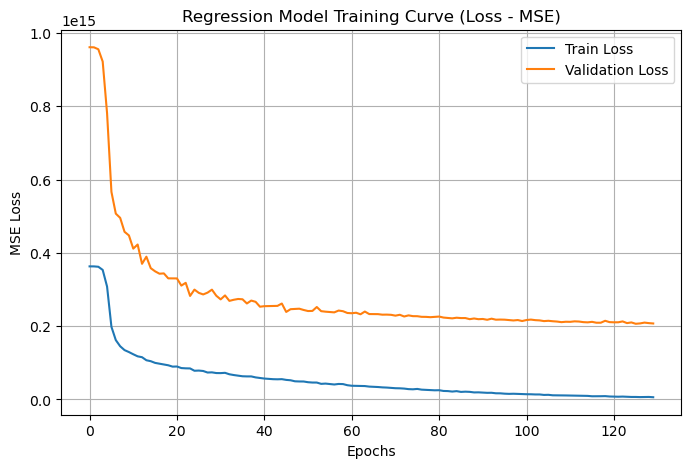

In [156]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Regression Model Training Curve (Loss - MSE)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

### _Sonuç_

_Tablodaki sonuçlara göre **Extra Tree Regressor** en başarılı modeldir (R² ≈ **0.85**). Onu **Gradient Boosting** ve **KNN** takip etmektedir. Doğrusal modeller (Linear, Ridge, Lasso) orta seviyede performans gösterirken, **SVR** ve **MLP** negatif R² değerleriyle veriyi yeterince açıklayamamıştır._

_Geliştirilen **Deep Learning (Keras)** modeli ise **R² ≈ 0.75** ile klasik doğrusal modellerden daha iyi, ancak ağaç tabanlı yöntemlerin gerisinde kalmıştır. Bu durum, kira/satış fiyatlarının doğrusal olmayan yapısını ağaç tabanlı modellerin daha iyi yakaladığını göstermektedir._